In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["JAX_LOG_COMPILES"] = "0"

import sys
import jax.numpy as np
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt

from jax import jit, random
from inrmri.dip import TimeDependant_DIP_Net, circle_generator
from inrmri.new_radon import ForwardRadonOperator, get_weight_freqs, make_forward_radon_operator
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import denoise_loss_batch, l1_loss, tikhonov_loss, tv_loss, create_center_mask
import optax 
from inrmri.advanced_training import train_with_updates_nspokeswise, OptimizerWithExtraState
import itertools
from inrmri.utils_rdls import get_predim_direct, get_shedule
from inrmri.utils_rdls import create_folder, save_frames_as_gif_with_pillow
from inrmri.utils_rdls import get_varying_keys, config_to_foldername
from inrmri.utils_rdls import plot_curves, plot_curves_and_mins, plot_multi_axis, multiple_images_visualization
from inrmri.utils_rdls import safe_normalize, get_center
from inrmri.utils import clear_jax_memory, parse_slices_list

import ast

2025-06-16 01:37:08.646810: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
def process_group(group):
    result = {}

    # 1. Scalar metrics → compute mean and std
    for metric in metrics_for_analysis:
        result[f'{metric}_mean'] = group[metric].mean()
        result[f'{metric}_std']  = group[metric].std()

    # 2. List-valued metrics → parse, stack, compute mean/std per position
    for col in metrics_list_for_analysis:
        try:
            lists = group[col].apply(ast.literal_eval).tolist()
            arr = np.array(lists, dtype=np.float32)
            result[f'{col}_mean'] = arr.mean(axis=0).tolist()
            result[f'{col}_std']  = arr.std(axis=0).tolist()
        except Exception as e:
            print(f"Error processing {col}: {e}")
            result[f'{col}_mean'] = np.nan
            result[f'{col}_std']  = np.nan

    # 3. Keep the first value of "stay_the_same" columns
    for col in stay_the_same:
        result[col] = group[col].iloc[0]

    return pd.Series(result)

In [3]:
volunteer = 'AA'
dataset = 'DATA_0.55T'
slices_list = [1,2]
total_slices = 8
base_path = '/mnt/workspace/datasets/pulseqCINE/'

In [4]:
print(f"Volunteer: {volunteer}")
print(f"Dataset: {dataset}")
print(f"Slices List: {slices_list}")
print(f"Total Slices: {total_slices}")
print(f"Base Path: {base_path}")

Volunteer: AA
Dataset: DATA_0.55T
Slices List: [1, 2]
Total Slices: 8
Base Path: /mnt/workspace/datasets/pulseqCINE/


In [5]:
# --- DATA ---
base_folder           = base_path + dataset + '/' + volunteer + '/'
train_data_folder     = base_folder + 'traindata/'
model_path            = base_folder + 'tdDIP/'
create_folder(model_path, reset=False)

In [6]:
# static parameters
dummy_iterations = 0 # iterations that are not shown in metrics
num_frames       = 30
saturation       = 0.3
perform_plots    = True
val_frames  = np.array([0]  , dtype=np.int32 )

In [7]:
# --- PARMETERS ---
key = random.PRNGKey(0)
key_net, key_params, key_train, key_latent = random.split(key,4) # keys for reproducibility
experiment_params = {
    'N':                    [256],
    'mapnet_layers':        [64],
    'cnn_latent_shape':     [8],
    'levels':               [4],
    'features':             [64],
    'iter':          [500],
    'learning_rate':        [1e-3],
    'batch_size':           [1,2],
    'addConst':             [False],
    'str_filter':           ['ramp'],
    'denoise_type':         ['tv'],
    'lambda_denoise_reg':   [0],
    'lr_schedule':          ['constant_schedule'],
    'lr_init_value':        [1e-3],
    'lr_end':               [1e-3],
    'lr_transition_steps':  [3000],
    'lr_decay_rate':        [0.90],
    'lr_staircase':         [False],
    'lr_power':             [20],
    'metric_step':          [50],
    'window_size':          [5],
    'nspokes':              [3],       # number of spokes used of each frame in the nspokes-wise training
    'nr_iqm':               [True],  # No-reference image quality metric
    'fr_iqm':               [True],  # Full-reference image quality metric
}
# Generate list of parameter combinations as dictionaries
keys = list(experiment_params.keys())
combinations = [dict(zip(keys, values)) for values in itertools.product(*experiment_params.values())]
# Identify the varying keys
varying_keys = get_varying_keys(combinations)
experiment_name = '_'.join(varying_keys)
# plot variables
xlim_botton = dummy_iterations
xlim_top    = int(np.max(np.array(experiment_params['iter'])))

slice: 1
Running configuration: {'step_to_save': 1000, 'N': 256, 'mapnet_layers': 64, 'cnn_latent_shape': 8, 'levels': 4, 'features': 64, 'total_kiter': 500, 'learning_rate': 0.001, 'batch_size': 1, 'addConst': False, 'str_filter': 'ramp', 'sqrt_filter': False, 'denoise_type': 'tv', 'lambda_denoise_reg': 0, 'lr_schedule': 'constant_schedule', 'lr_init_value': 0.001, 'lr_end': 0.001, 'lr_transition_steps': 3000, 'lr_decay_rate': 0.9, 'lr_staircase': False, 'lr_power': 20, 'metric_step': 50, 'window_size': 5, 'nspokes': 3, 'nr_iqm': True, 'fr_iqm': True, 'NFRAMES': 30, 'val_frames': Array([0], dtype=int32)}
[TRACING] Recompiling tDIP...


train iter:   0%|                                                                                                                                                                 | 0/501 [00:00<?, ?it/s]

[TRACING] Recompiling tDIP...
[TRACING] Recompiling tDIP...


train iter:   0%|▎                                                                                                                                                      | 1/501 [00:15<2:09:02, 15.49s/it]

[TRACING] Recompiling tDIP...


train iter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [01:20<00:00,  6.23it/s]


[TRACING] Recompiling tDIP...


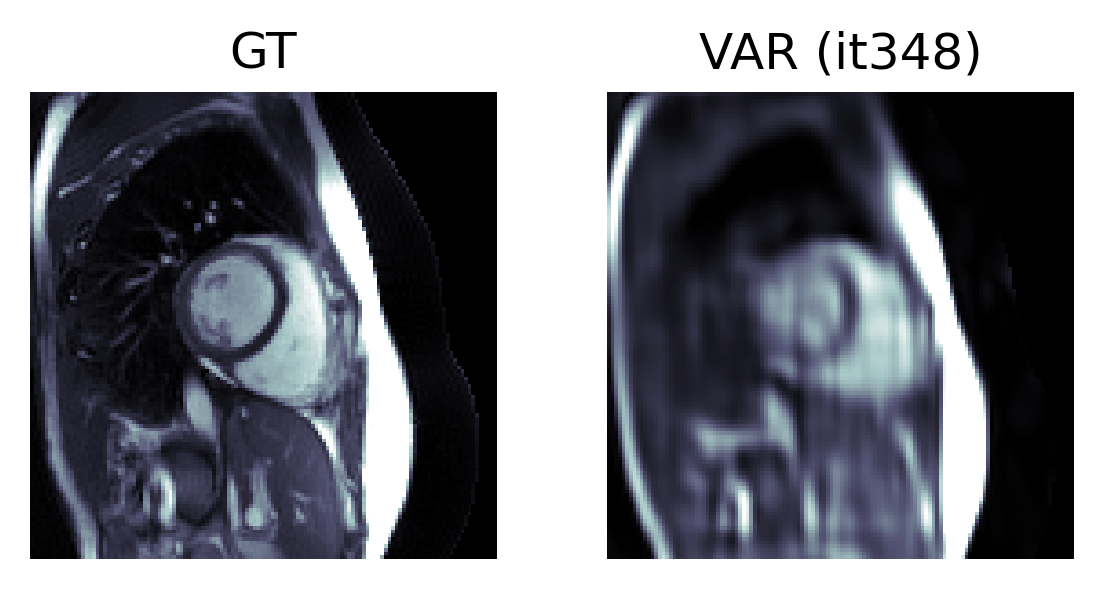

Running configuration: {'step_to_save': 1000, 'N': 256, 'mapnet_layers': 64, 'cnn_latent_shape': 8, 'levels': 4, 'features': 64, 'total_kiter': 500, 'learning_rate': 0.001, 'batch_size': 2, 'addConst': False, 'str_filter': 'ramp', 'sqrt_filter': False, 'denoise_type': 'tv', 'lambda_denoise_reg': 0, 'lr_schedule': 'constant_schedule', 'lr_init_value': 0.001, 'lr_end': 0.001, 'lr_transition_steps': 3000, 'lr_decay_rate': 0.9, 'lr_staircase': False, 'lr_power': 20, 'metric_step': 50, 'window_size': 5, 'nspokes': 3, 'nr_iqm': True, 'fr_iqm': True, 'NFRAMES': 30, 'val_frames': Array([0], dtype=int32)}
[TRACING] Recompiling tDIP...


train iter:   0%|                                                                                                                                                                 | 0/501 [00:00<?, ?it/s]

[TRACING] Recompiling tDIP...
[TRACING] Recompiling tDIP...


train iter:   0%|▎                                                                                                                                                      | 1/501 [00:16<2:19:44, 16.77s/it]

[TRACING] Recompiling tDIP...


train iter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [01:39<00:00,  5.03it/s]


[TRACING] Recompiling tDIP...


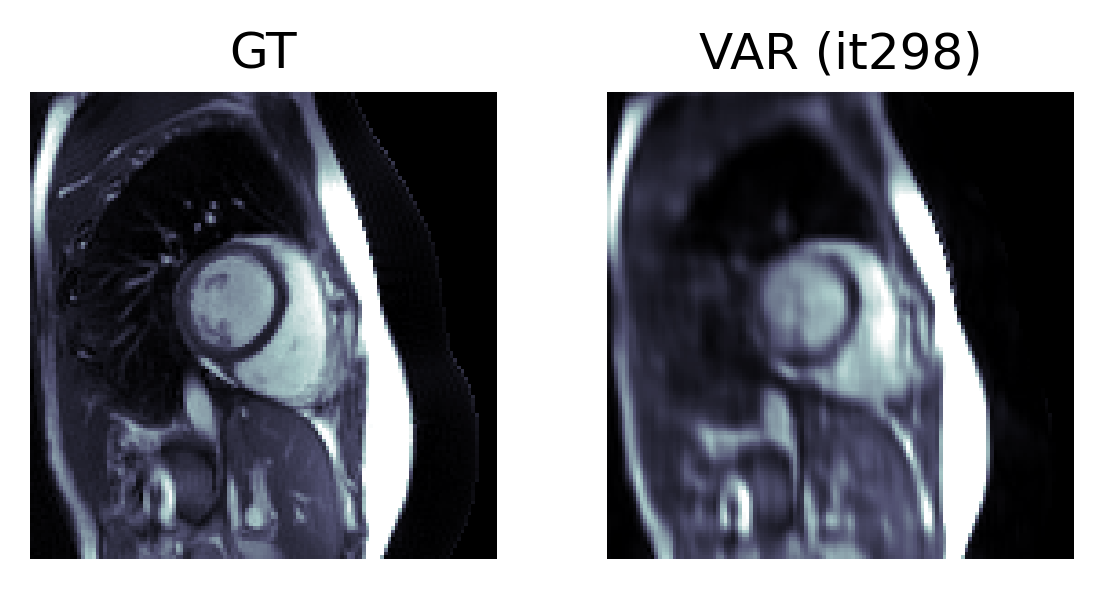

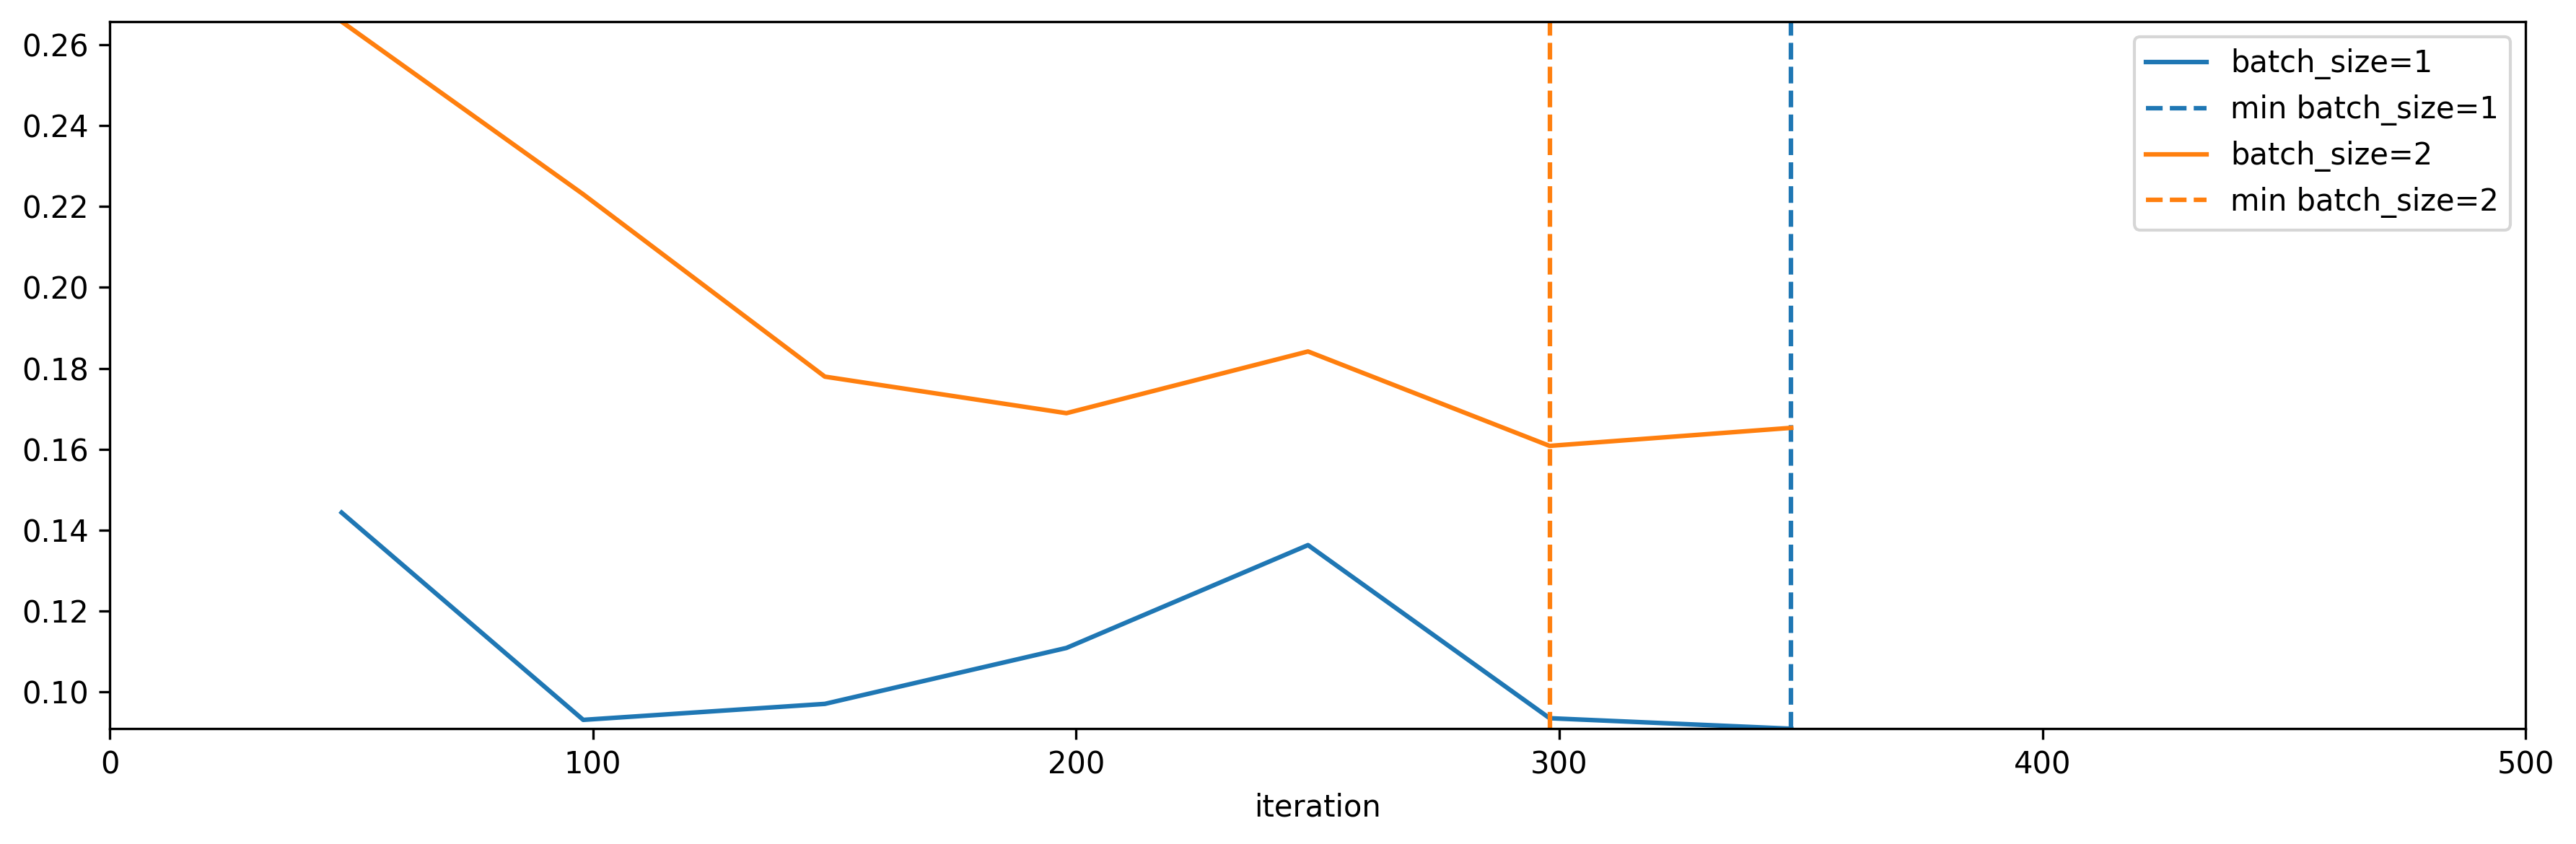

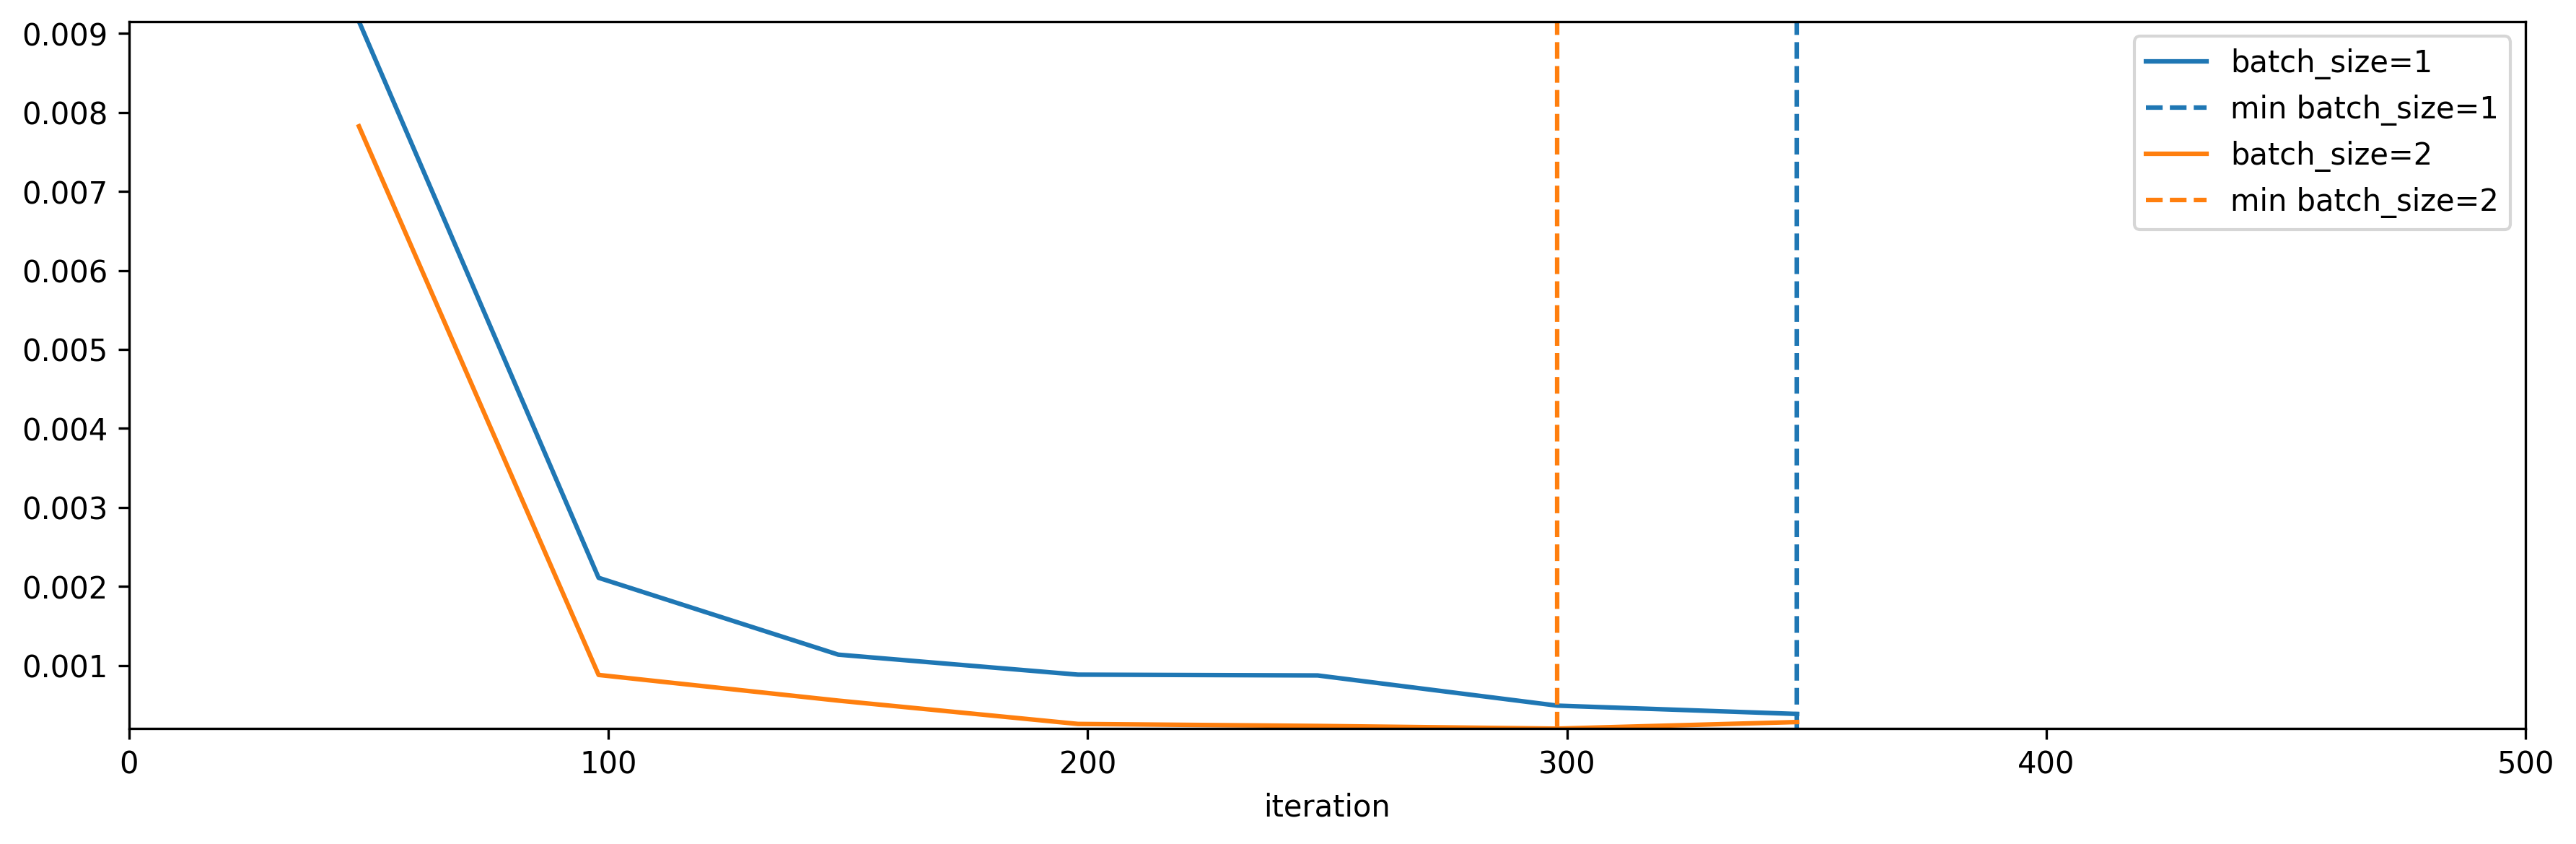

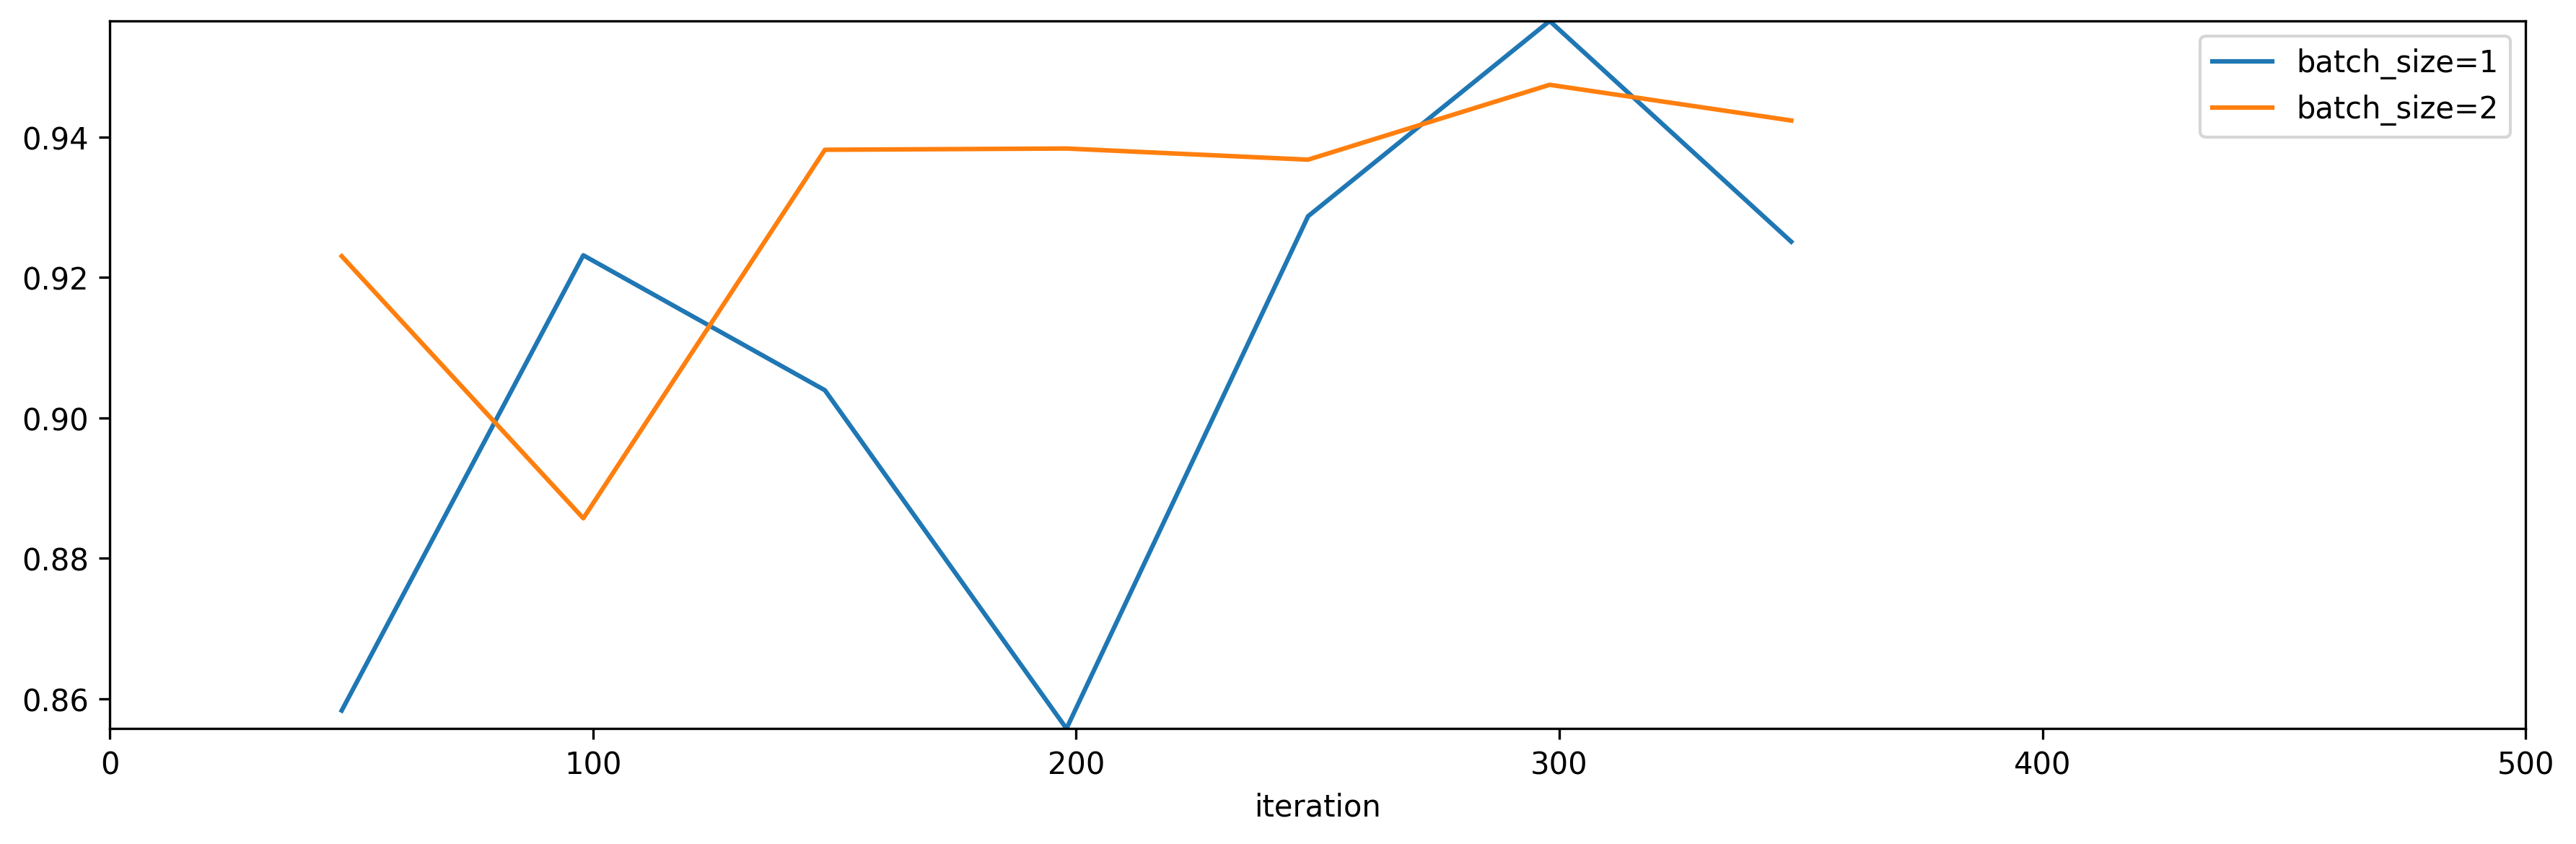

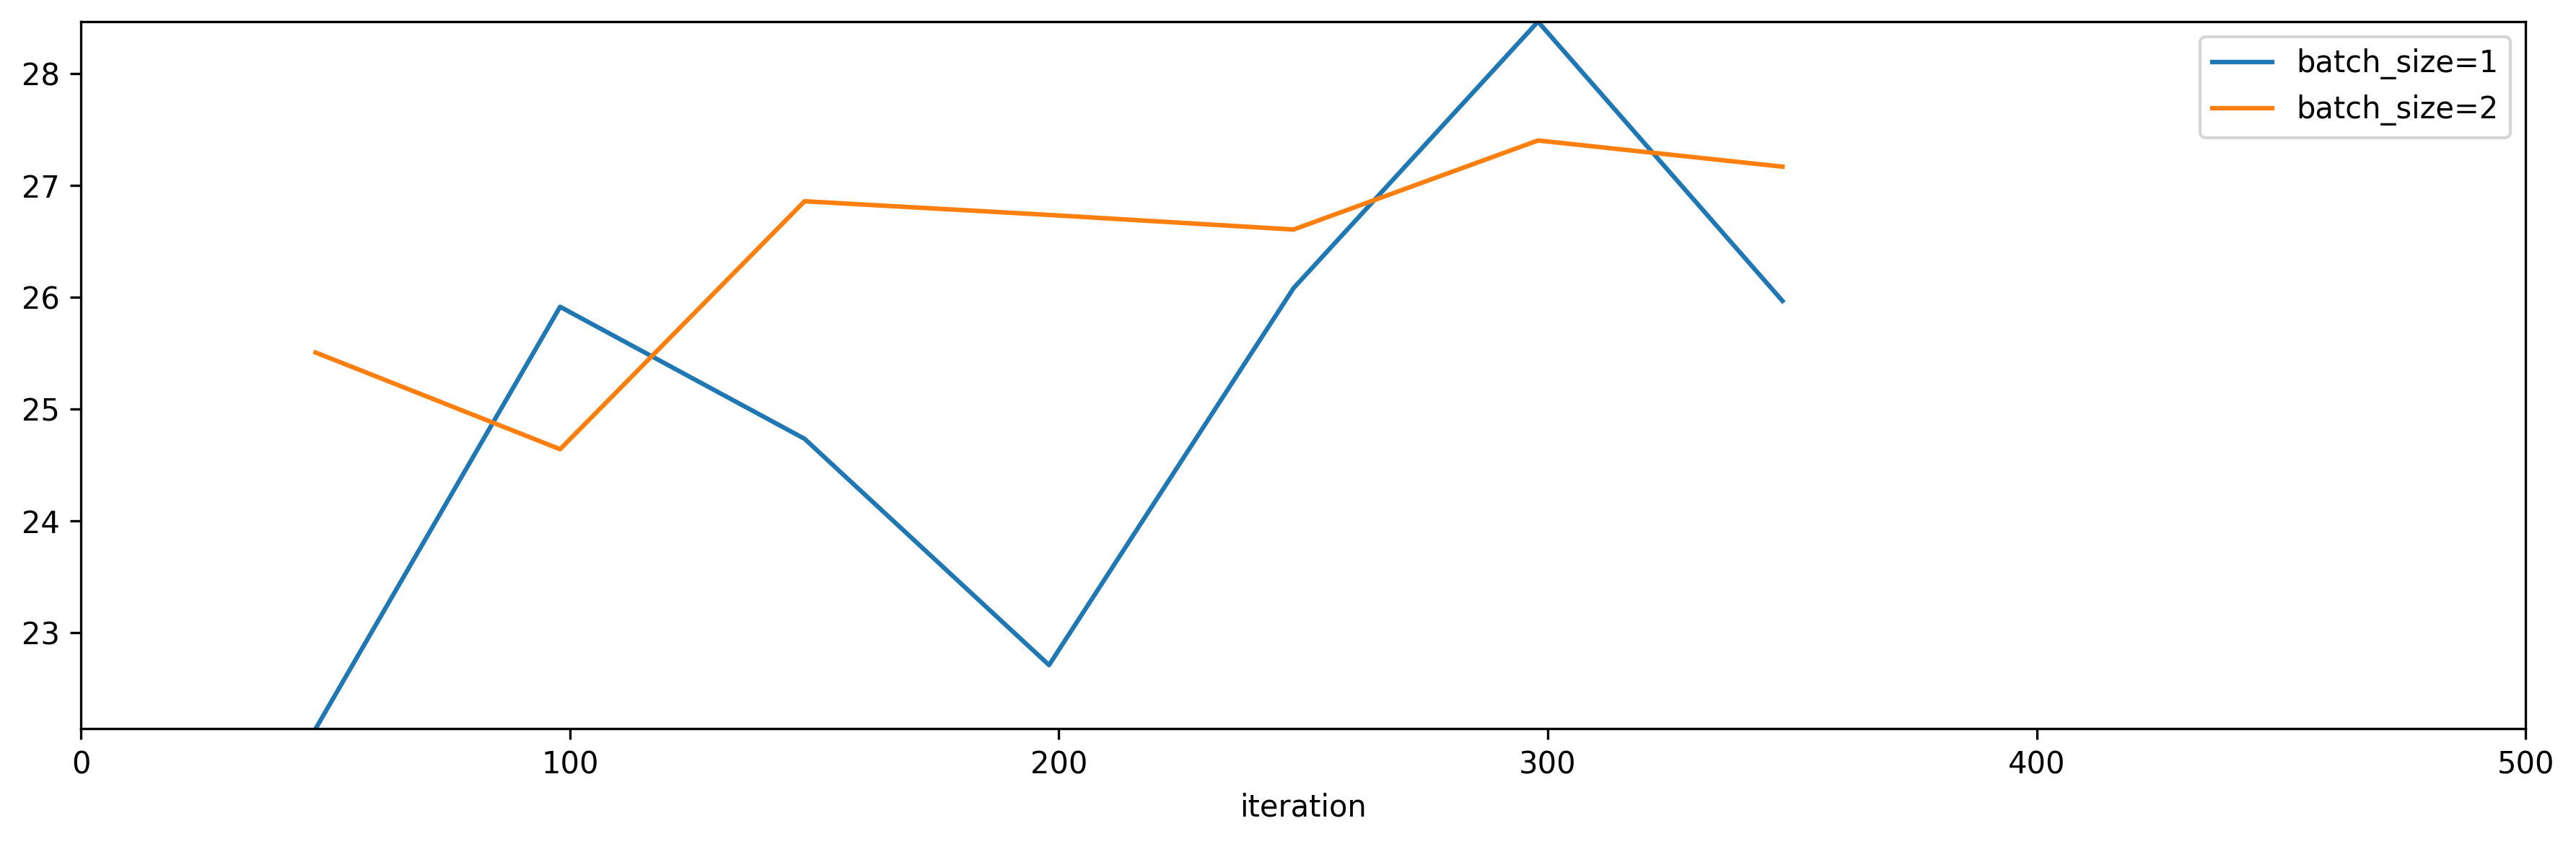

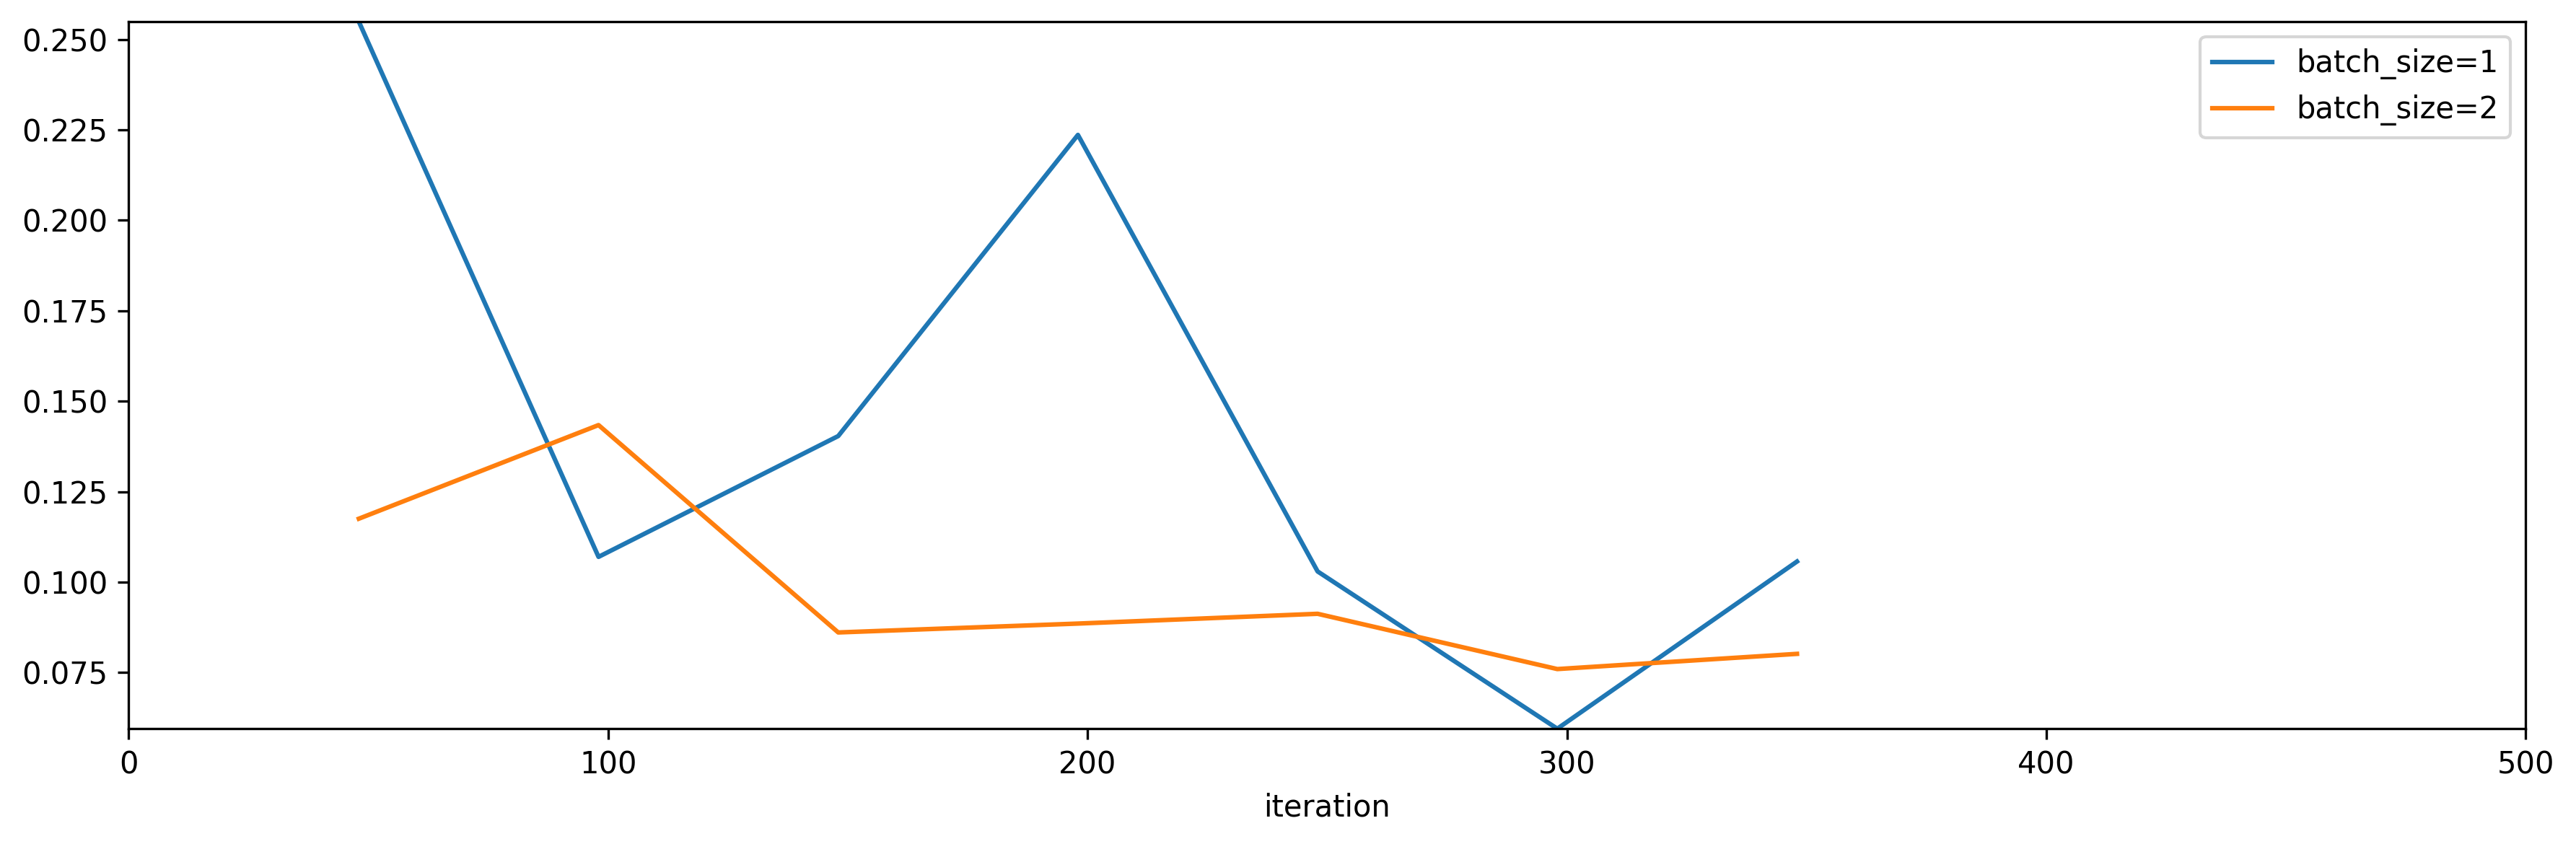

slice: 2
Running configuration: {'step_to_save': 1000, 'N': 256, 'mapnet_layers': 64, 'cnn_latent_shape': 8, 'levels': 4, 'features': 64, 'total_kiter': 500, 'learning_rate': 0.001, 'batch_size': 1, 'addConst': False, 'str_filter': 'ramp', 'sqrt_filter': False, 'denoise_type': 'tv', 'lambda_denoise_reg': 0, 'lr_schedule': 'constant_schedule', 'lr_init_value': 0.001, 'lr_end': 0.001, 'lr_transition_steps': 3000, 'lr_decay_rate': 0.9, 'lr_staircase': False, 'lr_power': 20, 'metric_step': 50, 'window_size': 5, 'nspokes': 3, 'nr_iqm': True, 'fr_iqm': True, 'NFRAMES': 30, 'val_frames': Array([0], dtype=int32)}
[TRACING] Recompiling tDIP...


train iter:   0%|                                                                                                                                                                 | 0/501 [00:00<?, ?it/s]

[TRACING] Recompiling tDIP...
[TRACING] Recompiling tDIP...


train iter:   0%|▎                                                                                                                                                      | 1/501 [00:11<1:33:04, 11.17s/it]

[TRACING] Recompiling tDIP...


train iter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [01:18<00:00,  6.36it/s]


[TRACING] Recompiling tDIP...


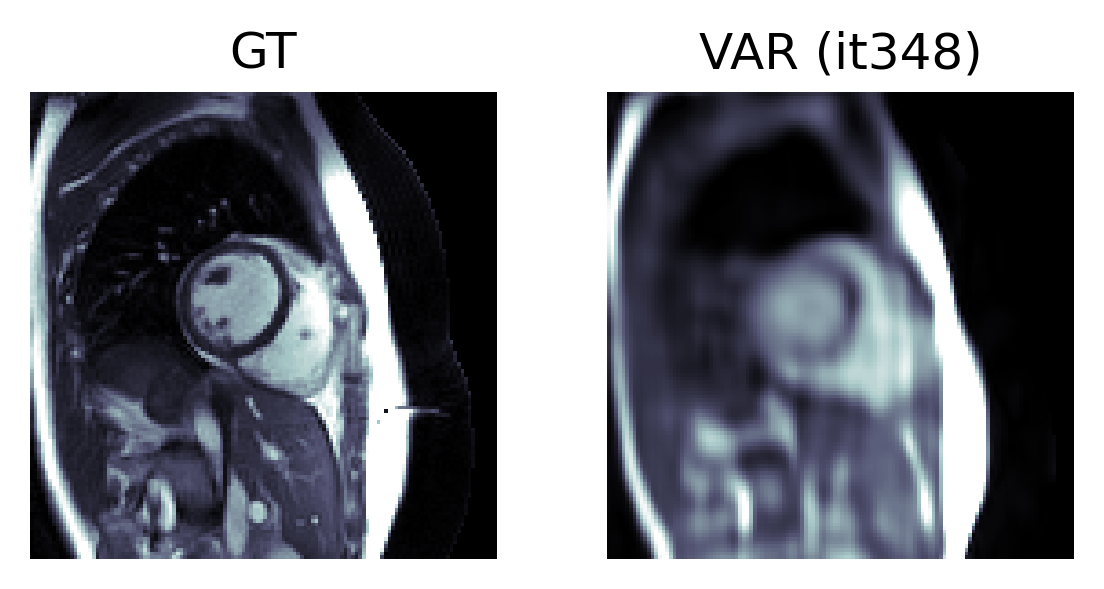

Running configuration: {'step_to_save': 1000, 'N': 256, 'mapnet_layers': 64, 'cnn_latent_shape': 8, 'levels': 4, 'features': 64, 'total_kiter': 500, 'learning_rate': 0.001, 'batch_size': 2, 'addConst': False, 'str_filter': 'ramp', 'sqrt_filter': False, 'denoise_type': 'tv', 'lambda_denoise_reg': 0, 'lr_schedule': 'constant_schedule', 'lr_init_value': 0.001, 'lr_end': 0.001, 'lr_transition_steps': 3000, 'lr_decay_rate': 0.9, 'lr_staircase': False, 'lr_power': 20, 'metric_step': 50, 'window_size': 5, 'nspokes': 3, 'nr_iqm': True, 'fr_iqm': True, 'NFRAMES': 30, 'val_frames': Array([0], dtype=int32)}
[TRACING] Recompiling tDIP...


train iter:   0%|                                                                                                                                                                 | 0/501 [00:00<?, ?it/s]

[TRACING] Recompiling tDIP...
[TRACING] Recompiling tDIP...


train iter:   0%|▎                                                                                                                                                      | 1/501 [00:15<2:05:48, 15.10s/it]

[TRACING] Recompiling tDIP...


train iter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [01:36<00:00,  5.17it/s]


[TRACING] Recompiling tDIP...


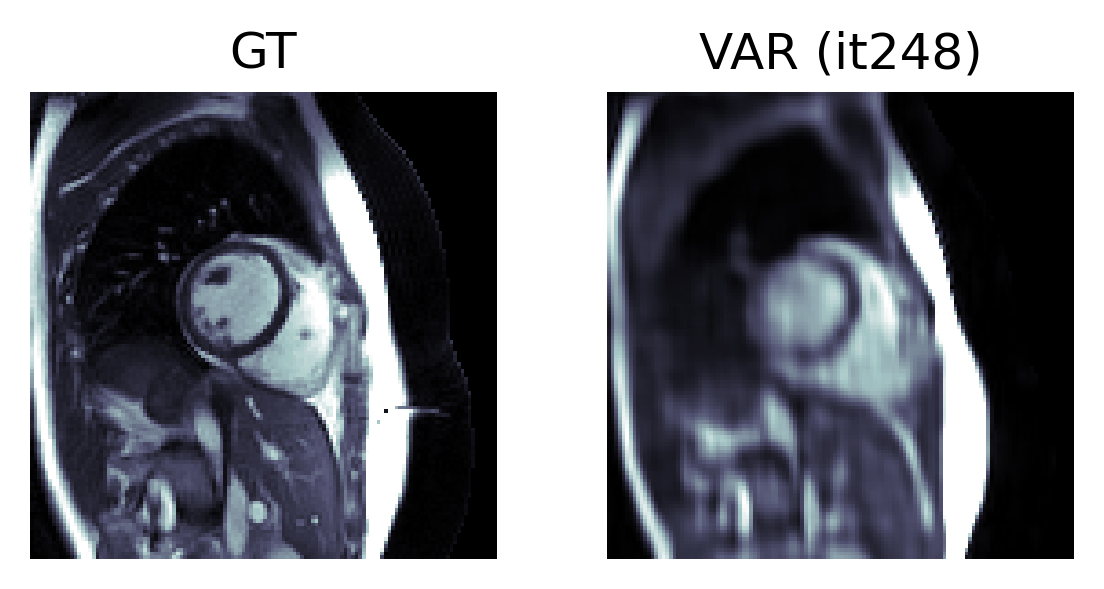

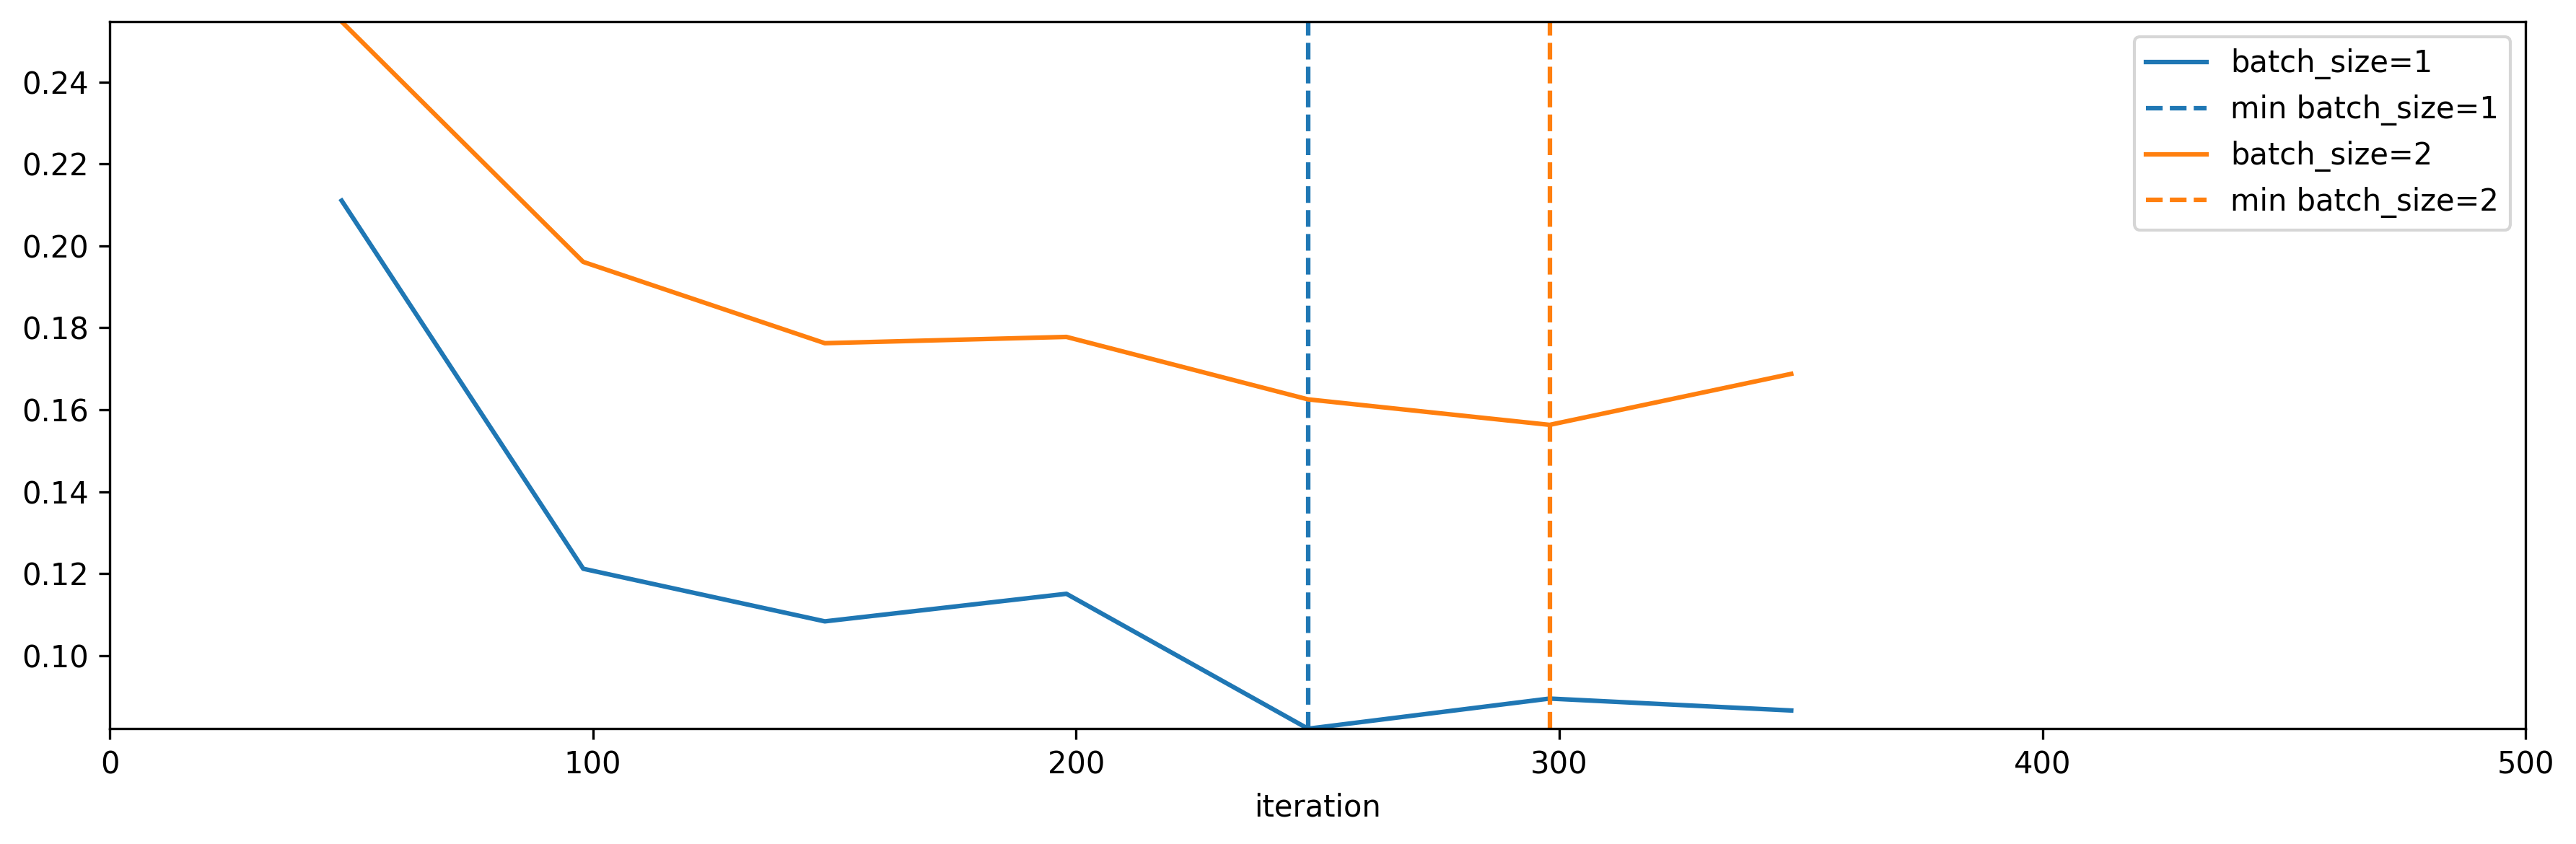

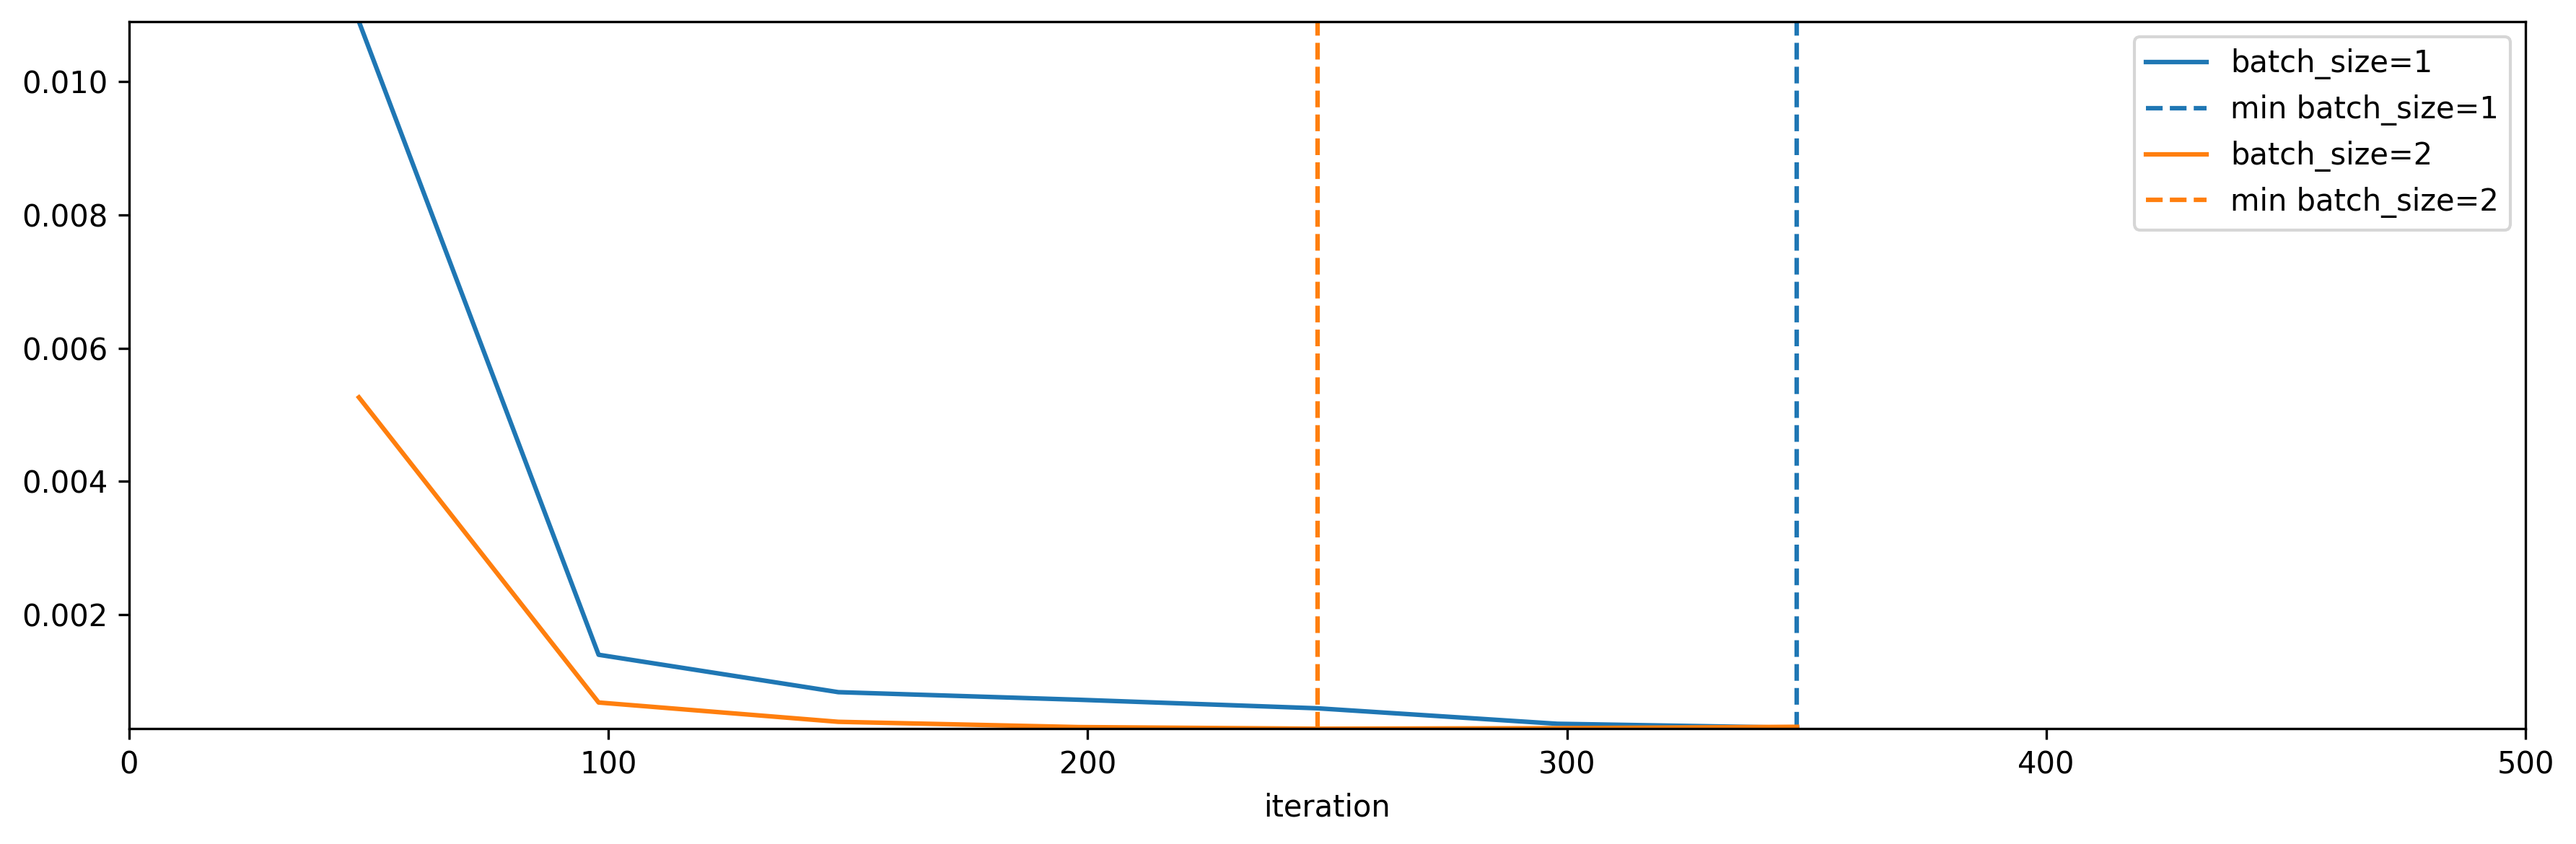

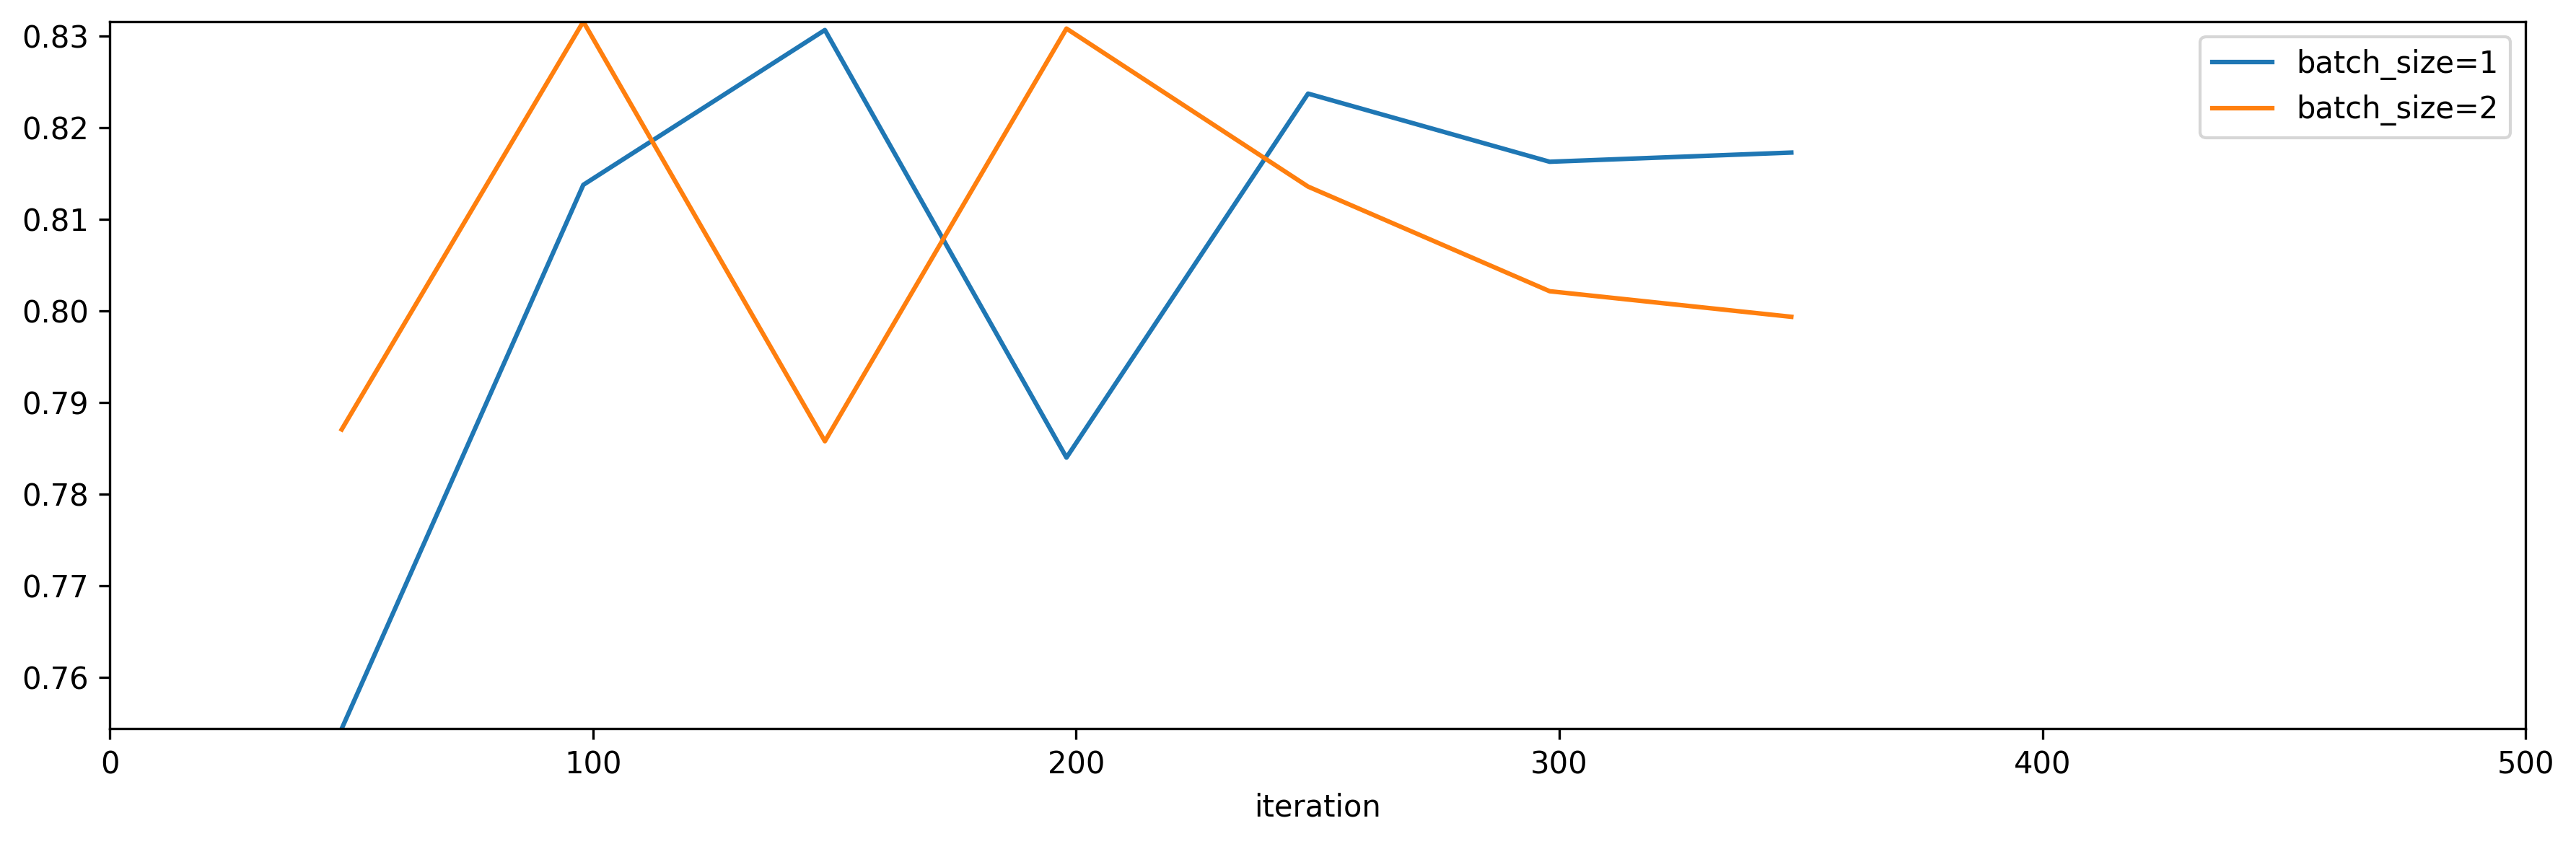

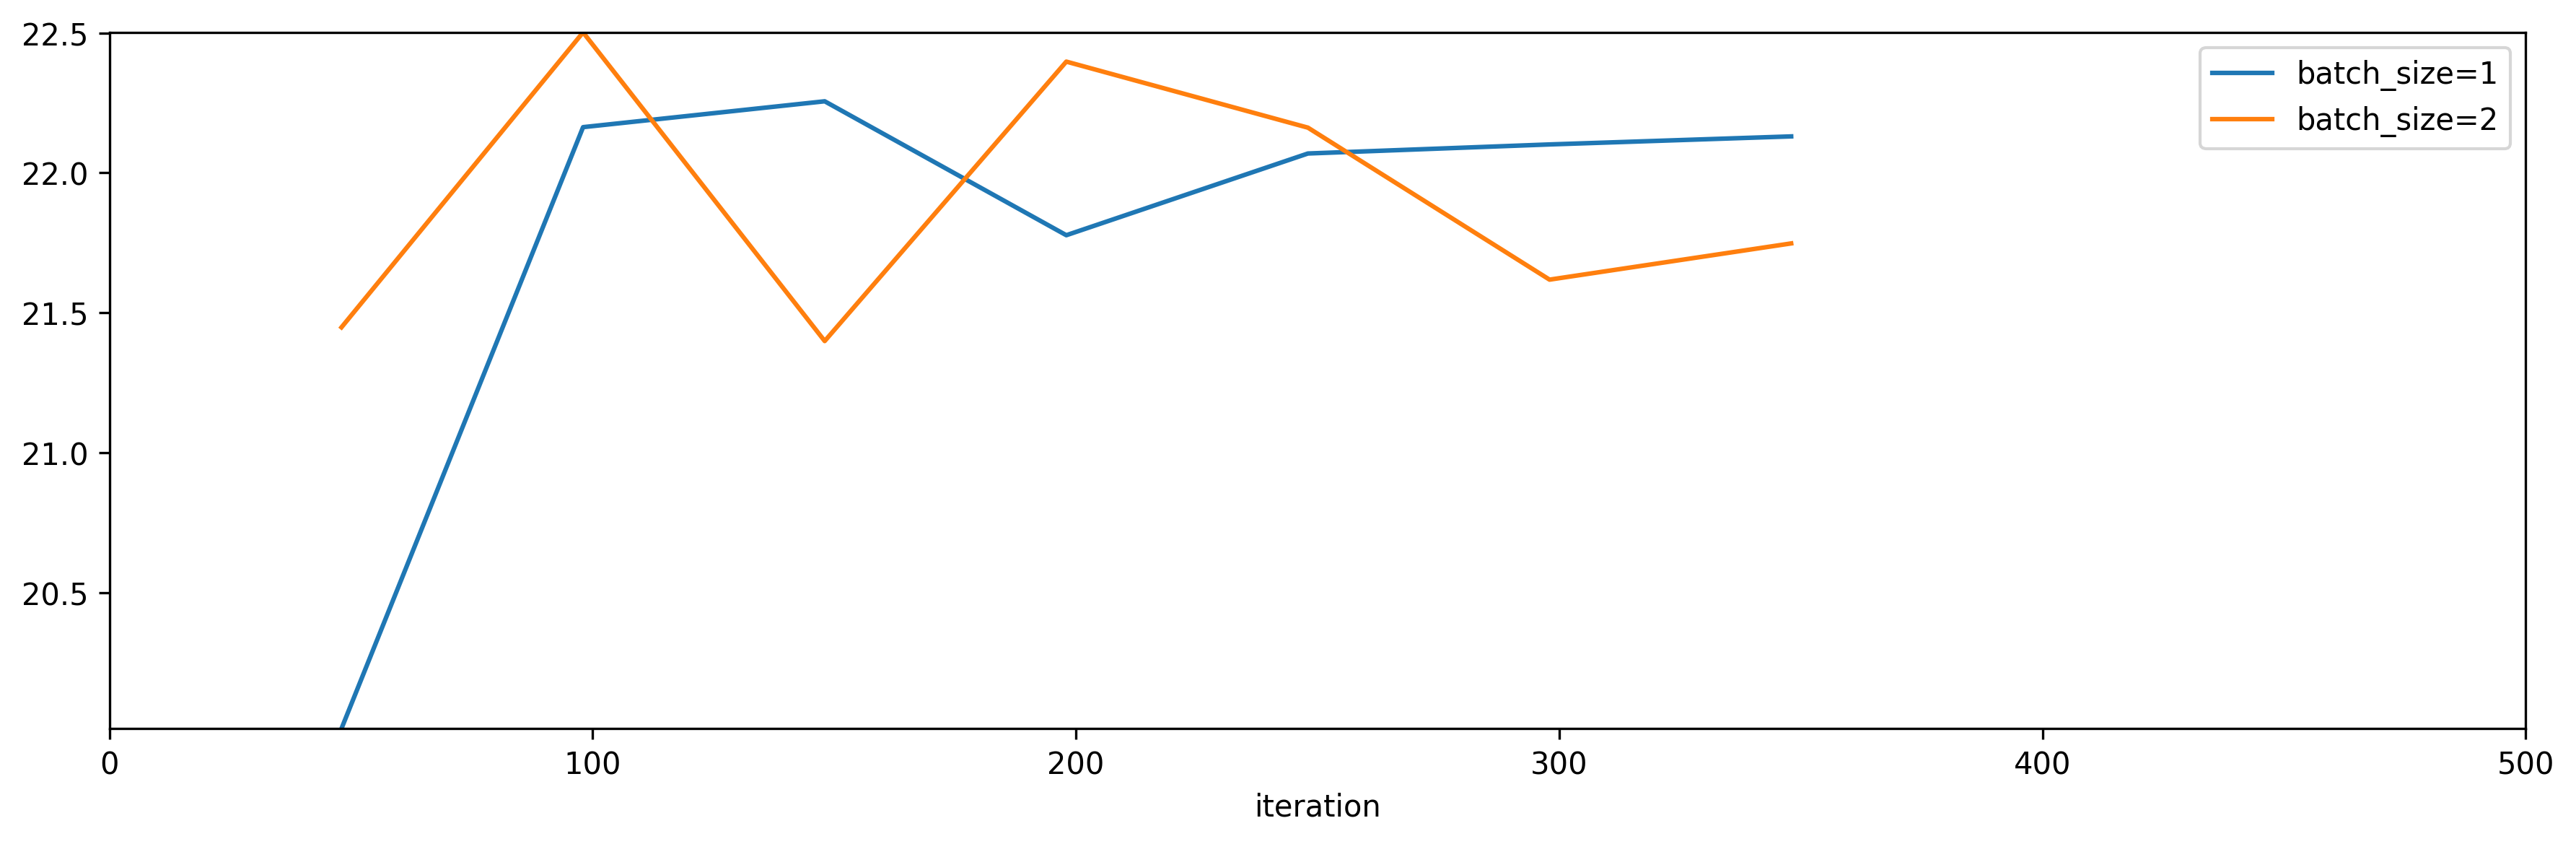

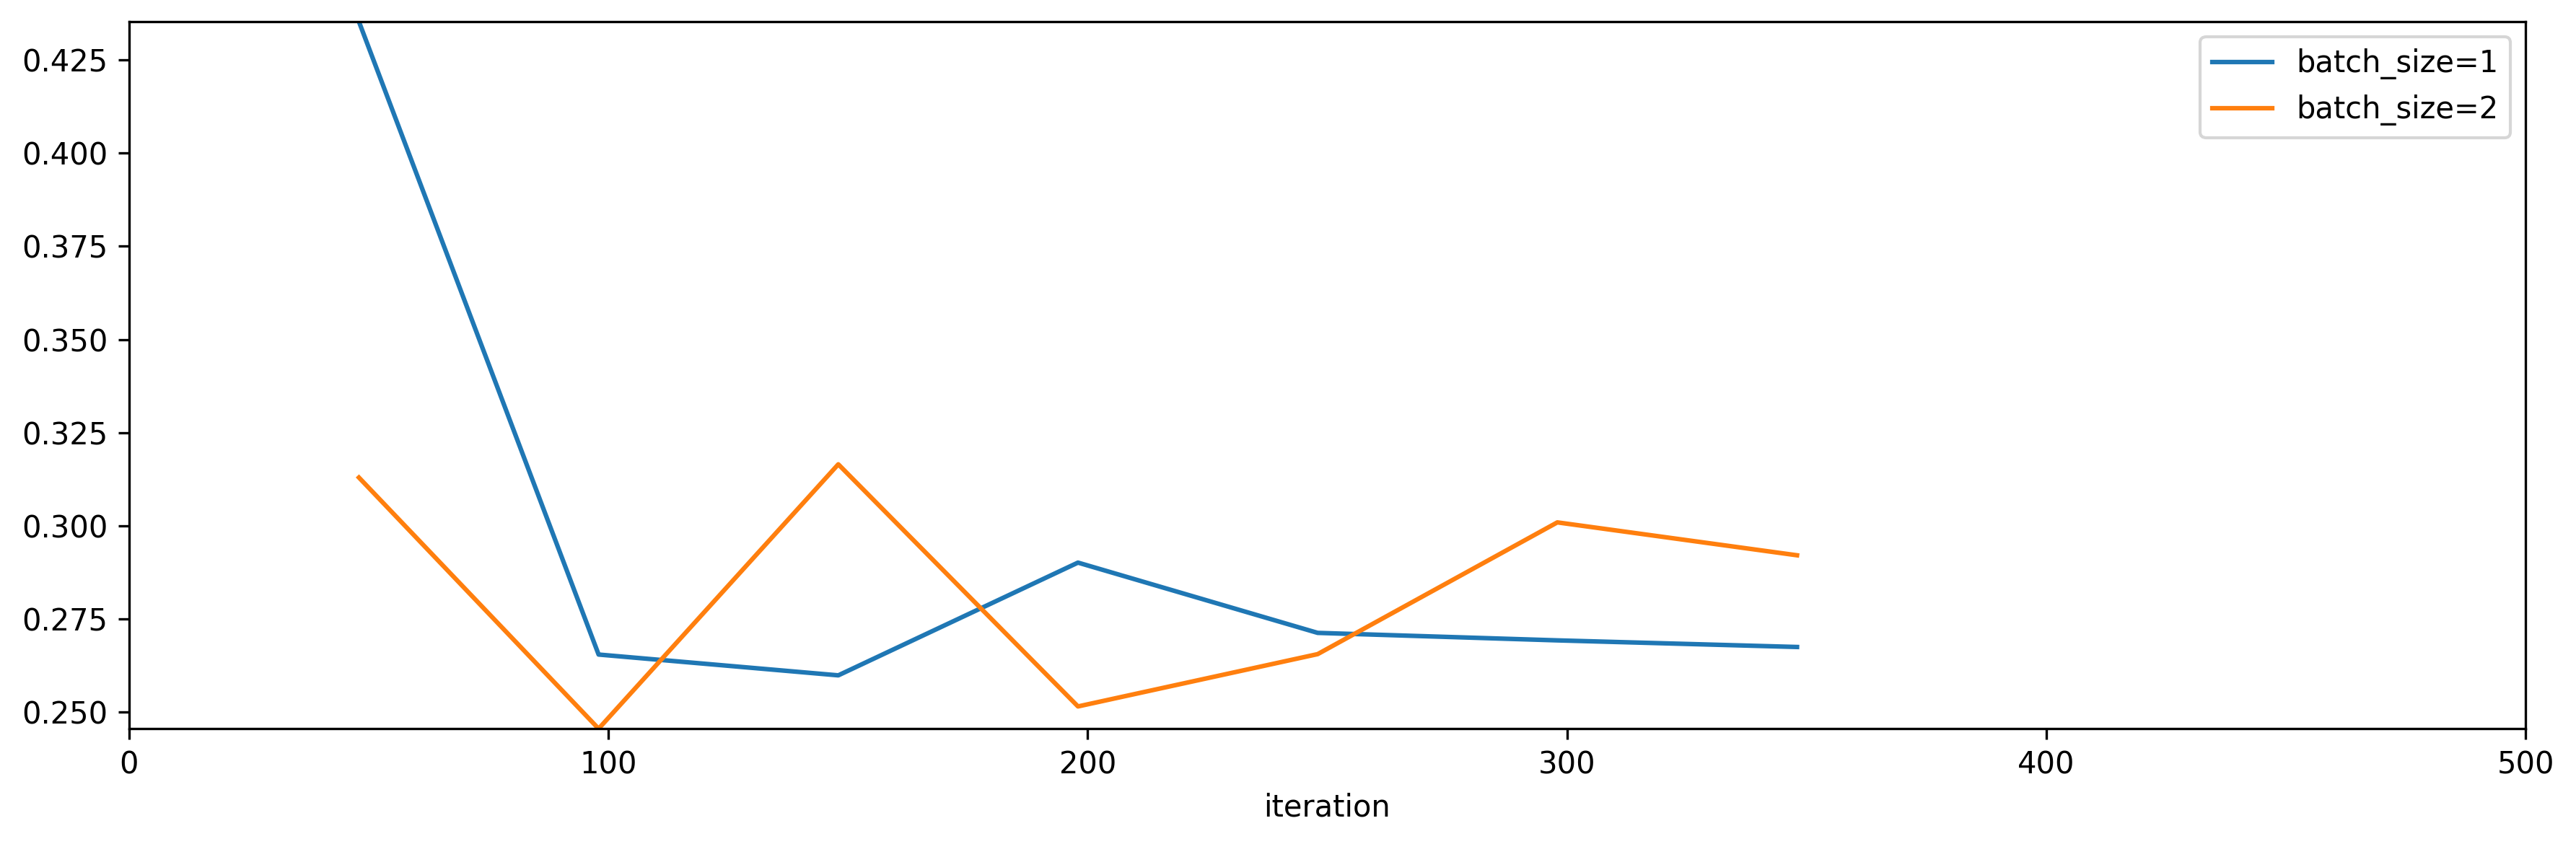

In [8]:
# --- SLICES LOOP ---
for slice_num in slices_list:
    print('slice: ' + str(slice_num))

    # metrics dataset
    experiment_records = []
    # --- specific dataset folder
    dataset_name          = 'slice_' + str(slice_num) + '_' + str(total_slices) +'_nbins' + str(num_frames)
    path_dataset          = train_data_folder + dataset_name + '.npz'
    save_folder           = model_path + dataset_name.replace(".", "_") + '/'
    create_folder(save_folder, reset=False)
    # load data
    data        =  onp.load(path_dataset)
    Y_data      =  data['Y_data']
    X_data      =  data['X_data']
    csm         =  data['csm']
    spclim      =  data['spclim']
    if dataset == 'DATA_0.55T':
        hollow_mask =  data['hollow_mask']
    else:
        hollow_mask =  data['hollow_mask_computed']
    recon_fs    =  data['recon_fs']
    recon_fs    = get_center(recon_fs) 
    recon_fs    = safe_normalize(recon_fs) 
    radon_operator = make_forward_radon_operator(csm, spclim)
    save_frames_as_gif_with_pillow(save_folder, recon_fs, filename='recon_fs', vmax=1, saturation=saturation, fps=30)
    # experiment folder
    exp_folder_path = save_folder + experiment_name + '/'
    create_folder(exp_folder_path, reset=True)
    # loop
    log_list            = [ ]
    training_names_list     = [ ]
    for i, h_params in enumerate(combinations):
        # add information
        h_params['NFRAMES'] = num_frames
        h_params['val_frames'] = val_frames
        print("Running configuration:", h_params)
        # training name
        training_name = config_to_foldername(h_params,varying_keys)
        training_folder = exp_folder_path + training_name + '/'
        create_folder(training_folder, reset=True)
        training_names_list.append(  training_name  )
        # model
        CONFIG_NET = {
            'mapnet_layers':[h_params['mapnet_layers'], h_params['mapnet_layers'],],
            'cnn_latent_shape':(h_params['cnn_latent_shape'],h_params['cnn_latent_shape']),
            'levels':h_params['levels'],
            'features':h_params['features']
        }
        net = TimeDependant_DIP_Net(
            key_latent = key_latent,
            addConst = h_params['addConst'],
            nframes= num_frames,
            latent_generator=circle_generator,
            imshape=[h_params['N'],h_params['N']],
            **CONFIG_NET
            )
        params = net.init_params(key_params)
        WEIGHT_FREQS = get_weight_freqs(  h_params['N'], h_params['str_filter']  )
        schedule       = get_shedule(h_params)
        optimizer      = OptimizerWithExtraState(optax.adam(learning_rate=schedule))   
        lambda_denoise_reg = h_params['lambda_denoise_reg']
        center_mask    = create_center_mask((h_params['N'],h_params['N']))
        if h_params['denoise_type'] == 'tv':
            den_loss = tv_loss
        elif h_params['denoise_type'] == 'tikhonov':
            den_loss = tikhonov_loss
        elif h_params['denoise_type'] == 'l1':
            den_loss = l1_loss
        else:
            raise ValueError(f"Unknown denoise_type: {h_params['denoise_type']}")
        # functions
        def loss(params, X, Y, index_frames, spoke2image, key):
            #print('loss function')
            epsilon = 1e-4
            # reconstruct image
            ims, update     = net.train_forward_pass(params, key, index_frames)            # (frames, px, py)
            #print('ims.shape :' + str(ims.shape))
            # compute the loss
            total_loss = 0
            for i in range(len(spoke2image)):
                image_index = spoke2image[i]
                # data
                im            = np.expand_dims(ims[image_index] ,  axis=0)      # Preserves leading dimension
                #print('im.shape :' + str(im.shape))
                Y_data_frame  = np.expand_dims(Y[i],  axis=0)                          # Preserves leading dimension
                #print('Y_data_frame.shape :' + str(Y_data_frame.shape))
                alphas_frame  = np.expand_dims(X[i,0] ,  axis=0)                        # Preserves both leading and feature dimension
                #print('alphas_frame.shape :' + str(alphas_frame.shape))
                # preprocess
                Y_data_frame = Y_data_frame[...,0] # (frames, cmap, nx)
                #print('Y_data_frame.shape :' + str(Y_data_frame.shape))
                # loss computation
                spoke_radon_kspace = radon_operator(im, alphas_frame)  
                #print('spoke_radon_kspace.shape :' + str(spoke_radon_kspace.shape))
                loss_value = weighted_loss(spoke_radon_kspace, Y_data_frame, (1. + WEIGHT_FREQS)[None,None,:])
                total_loss += loss_value 
                total_loss += lambda_denoise_reg * denoise_loss_batch(im[0, :, :][..., None], den_loss, center_mask)
            return total_loss, update
            
        def recon_cine(params, t_idx, hollow_mask):                    
            ims, _ = net.train_forward_pass(params, key, t_idx)                                  # (frames, px, py)  
            ims    = np.moveaxis(ims, 0, -1)                                                     # (px, py, frames) 
            masks  = (1 - hollow_mask)                                                           # (px, py)                    
            ims    = ims * masks[:,:,None]                                                       # (px, py, frames)
            ims    = get_center(ims)                                                             # (px//2, py//2, frames)
            ims    = safe_normalize(ims)                                        # (px//2, py//2, frames)
            return ims
        # training
        results = train_with_updates_nspokeswise(jit(loss), jit(recon_cine), X_data, Y_data, hollow_mask, params, optimizer, key_train, h_params, reference = recon_fs[:,:,val_frames])
        # --- memory management (post-training)---
        del optimizer, schedule, WEIGHT_FREQS
        clear_jax_memory()
        # save records
        record = {key: h_params[key] for key in varying_keys}
        record['duration [s]']    = results['time_s']
        record['duration [min]']  = results['time_s'] / 60
        record['duration']        = results['time_str']
        record['experiment_folder'] = exp_folder_path 
        record['training_name']     = training_name
        record['training_folder']   = training_folder
        for var_name in ['it', 'loss', 'var', 'ssim', 'psnr', 'ap']:
            record[var_name]            = results['best_metrics'][var_name]
        experiment_records.append(record)
        # save the best recon
        best_recon    = get_predim_direct(net, hollow_mask, key, h_params, results['best_metrics']['params'])
        np.savez(training_folder + 'best_recon' + '.npz', **{'best_recon':best_recon,  **h_params, **record})
        
        save_frames_as_gif_with_pillow(training_folder, best_recon, filename='best_recon', vmax=1, saturation=saturation, fps=num_frames)
        if perform_plots:
            log_list.append(  results['log_queue']  )
            # save the log
            item_save_path = os.path.join(training_folder, 'log_queue.npz')
            np.savez(item_save_path, **results['log_queue'])
            
            if h_params['nr_iqm']:
                # save NR-IQM curves
                plot_multi_axis(
                    results['log_queue']['it'], 
                    [ results['log_queue']['var'] ], 
                    ['VAR'], 
                    xlim=(xlim_botton, h_params['iter']), 
                    save_path = training_folder + 'nr_iqm_curves.png'
                )
                # save NR-IQM images
                multiple_images_visualization(
                    [recon_fs, best_recon], 
                    ['GT', 'VAR (it' + str(results['best_metrics']['it'])  + ')'],  
                    frame = 0,
                    save_path = training_folder + 'nr_iqm_images.png',
                    saturation=saturation
                )

            if h_params['fr_iqm']:
                # save FR-IQM curves
                plot_multi_axis(
                    results['log_queue']['it'], 
                    [results['log_queue']['psnr'], results['log_queue']['ssim'], results['log_queue']['ap'] ], 
                    ['PSNR', 'SSIM', 'AP'], 
                    xlim=(xlim_botton, h_params['iter']), 
                    save_path = training_folder + 'fr_iqm_curves.png'
                )
        # --- memory management (combinatory-level) ---
        del net, params, results, best_recon
        clear_jax_memory()
        plt.close('all')

    df = pd.DataFrame(experiment_records)
    df.to_csv(exp_folder_path + "experiment_records.csv", index=False, sep=';')
    if perform_plots:
        # metric curves
        image_path = exp_folder_path + 'curves_' + 'loss' + '.png'
        plot_curves_and_mins(log_list, training_names_list, 'loss', save_path = image_path, xlim=(xlim_botton, xlim_top))
        if h_params['nr_iqm']:
            image_path = exp_folder_path + 'curves_' + 'var' + '.png'
            plot_curves_and_mins(log_list, training_names_list, 'var', save_path = image_path, xlim=(xlim_botton, xlim_top))
        if h_params['fr_iqm']:
            for r_iqm in ['ssim', 'psnr', 'ap']:
                # metric curves
                image_path = exp_folder_path + 'curves_' + r_iqm + '.png'
                plot_curves(log_list, training_names_list, r_iqm, save_path = image_path, xlim=(xlim_botton, xlim_top))
    # --- memory management (slice-level) ---
    del X_data, Y_data, csm, spclim, hollow_mask, recon_fs, data
    clear_jax_memory()

In [9]:
training_name

'batch_size=2'

## Post-processing

In [10]:
metrics_for_analysis = ['var', 'ssim', 'psnr', 'ap', 'duration [s]', 'duration [min]']
metrics_list_for_analysis = ['log_var', 'log_ssim', 'log_psnr', 'log_ap', 'log_loss', 'log_time']
stay_the_same = ['it', 'log_it', 'training_name']
variables = varying_keys

In [11]:
# create general dataset
count = 0
for i in slices_list:
  experiment_path = model_path + 'slice_'+str(i)+'_'+str(total_slices)+'_nbins30' + '/'+experiment_name   
  csv_path = experiment_path + "/experiment_records.csv"
  if count == 0:
    df_slices = pd.read_csv(csv_path, delimiter=';')
    df_slices['slice'] = i
    count+=1
  else:
    df = pd.read_csv(csv_path, delimiter=';')
    df['slice'] = i
    df_slices = pd.concat([df_slices, df])

df_total = df_slices.reset_index(drop=True)
df_total.head()

,batch_size,duration [s],duration [min],duration,experiment_folder,training_name,training_folder,it,loss,var,ssim,psnr,ap,slice
0,1,80.626517,1.343775,0h 1m 20.63s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=1,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,348,0.090888,0.000384,0.925105,25.967438,0.105690,1
1,2,99.732120,1.662202,0h 1m 39.73s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=2,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,298,0.160819,0.000199,0.947455,27.401766,0.075963,1
2,1,78.924820,1.315414,0h 1m 18.92s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=1,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,348,0.086617,0.000302,0.817306,22.130344,0.267488,2
3,2,96.989408,1.616490,0h 1m 36.99s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=2,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,248,0.162539,0.000287,0.813588,22.161547,0.265573,2


In [12]:
for index, row in df_total.iterrows():
    folder_name_list = []
    log_path = row['training_folder'] + 'log_queue.npz'
    log_queue = np.load(log_path)
    for key  in log_queue.keys():    
        df_total.at[index, 'log_'+key] = str(log_queue[key].tolist())
df_total.head()

,batch_size,duration [s],duration [min],duration,experiment_folder,training_name,training_folder,it,loss,var,...,psnr,ap,slice,log_it,log_time,log_var,log_loss,log_ssim,log_psnr,log_ap
0,1,80.626517,1.343775,0h 1m 20.63s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=1,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,348,0.090888,0.000384,...,25.967438,0.105690,1,"[48, 98, 148, 198, 248, 298, 348]","[29.770835876464844, 35.3448486328125, 41.0905...","[0.00915453676134348, 0.0021083150058984756, 0...","[0.1443280577659607, 0.09307263046503067, 0.09...","[0.8583412170410156, 0.9231757521629333, 0.903...","[22.1440486907959, 25.91514015197754, 24.73514...","[0.2549024820327759, 0.10697053372859955, 0.14..."
1,2,99.732120,1.662202,0h 1m 39.73s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=2,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,298,0.160819,0.000199,...,27.401766,0.075963,1,"[48, 98, 148, 198, 248, 298, 348]","[35.21732711791992, 42.41922378540039, 49.5592...","[0.007825707085430622, 0.0008783015073277056, ...","[0.2657187581062317, 0.22302457690238953, 0.17...","[0.9230441451072693, 0.8857210278511047, 0.938...","[25.506610870361328, 24.642255783081055, 26.85...","[0.11752143502235413, 0.14340120553970337, 0.0..."
2,1,78.924820,1.315414,0h 1m 18.92s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=1,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,348,0.086617,0.000302,...,22.130344,0.267488,2,"[48, 98, 148, 198, 248, 298, 348]","[25.60329818725586, 31.981910705566406, 38.031...","[0.010900121182203293, 0.0013969694264233112, ...","[0.21103811264038086, 0.12120798975229263, 0.1...","[0.7543529272079468, 0.8137802481651306, 0.830...","[20.015718460083008, 22.163387298583984, 22.25...","[0.4352789521217346, 0.2654609680175781, 0.259..."
3,2,96.989408,1.616490,0h 1m 36.99s,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,batch_size=2,/mnt/workspace/datasets/pulseqCINE/DATA_0.55T/...,248,0.162539,0.000287,...,22.161547,0.265573,2,"[48, 98, 148, 198, 248, 298, 348]","[32.99300003051758, 39.988807678222656, 47.063...","[0.00526054110378027, 0.0006803058786317706, 0...","[0.2547135353088379, 0.19608397781848907, 0.17...","[0.7870532274246216, 0.8316126465797424, 0.785...","[21.44855308532715, 22.501779556274414, 21.399...","[0.3129565715789795, 0.2455621212720871, 0.316..."


In [13]:
df_total.to_csv(model_path + experiment_name + ".csv" , index=False, sep=';')

In [14]:
summary_df = df_total.groupby(variables).apply(process_group).reset_index()

/tmp/ipykernel_3700281/2197199884.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = df_total.groupby(variables).apply(process_group).reset_index()


In [15]:
summary_df.to_csv(model_path + experiment_name + "_summary.csv" , index=False, sep=';')

In [16]:
summary_df

,batch_size,var_mean,var_std,ssim_mean,ssim_std,psnr_mean,psnr_std,ap_mean,ap_std,duration [s]_mean,...,log_psnr_std,log_ap_mean,log_ap_std,log_loss_mean,log_loss_std,log_time_mean,log_time_std,it,log_it,training_name
0,1,0.000343,0.000058,0.871205,0.076226,24.048891,2.713235,0.186589,0.114409,79.775669,...,"[1.0641651153564453, 1.8758764266967773, 1.239...","[0.34509071707725525, 0.18621575832366943, 0.2...","[0.09018823504447937, 0.07924521714448929, 0.0...","[0.17768308520317078, 0.10714031010866165, 0.1...","[0.03335502743721008, 0.014067679643630981, 0....","[27.68706703186035, 33.66337966918945, 39.5607...","[2.083768844604492, 1.6814689636230469, 1.5297...",348,"[48, 98, 148, 198, 248, 298, 348]",batch_size=1
1,2,0.000243,0.000062,0.880521,0.094658,24.781656,3.705394,0.170768,0.134075,98.360764,...,"[2.02902889251709, 1.0702381134033203, 2.72948...","[0.2152390033006668, 0.19448167085647583, 0.20...","[0.09771756082773209, 0.051080457866191864, 0....","[0.2602161467075348, 0.2095542848110199, 0.177...","[0.005502611398696899, 0.013470299541950226, 0...","[34.10516357421875, 41.204017639160156, 48.311...","[1.1121635437011719, 1.2152080535888672, 1.247...",298,"[48, 98, 148, 198, 248, 298, 348]",batch_size=2
